## Imports

In [1]:
import numpy as np
import time
import datetime
import random

from keras.callbacks import LambdaCallback
from keras.utils import plot_model
from keras.callbacks import TensorBoard

from pandas import read_csv
from Audio.Components.MidiPlayer import MidiPlayer

from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

from NN.networks.simple_model import create_model

from Audio.Components.helpers.prepare_arrays import get_categorized_variables
from Audio.Components.helpers.save_model import save_model
from Audio.Components.helpers.make_encoded_prediction import make_encoded_prediction
from Audio.Components.helpers.create_categorical_indicies import create_category_indicies, create_lookup_indicies
from Audio.Components.helpers.generate_phrases import generate_phrases
from Audio.Components.helpers.decode_predictions import decode_predictions
from Audio.Components.helpers.play_generated_phrase import play_generated_phrase
from Audio.Components.helpers.vectorize_phrases import vectorize_phrases
from Audio.Components.helpers.logger import logger
from Helpers.map_midi_to_note_number import map_midi_to_note_number
from Helpers.map_midi_to_interval import map_midi_to_interval
import constants

/Users/dannymeyer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [2]:
player = MidiPlayer()
dropout = 0.5
n_time_steps = constants.n_time_steps
semi_redundancy_step = constants.semi_redundancy_step
lstm_size = 10
lr = constants.lr
epochs = constants.epochs
batch_size = constants.batch_size
n_to_generate = constants.n_to_generate

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [3]:
logger('PREPROCESSING')
corpus = read_csv('Audio/data/input.csv', header=1)
print('corpus length:', len(corpus))
notes_corpus = corpus.values[:, 0]
note_name_corpus = corpus.values[:, 1]
interval_corpus = corpus.values[:, 2]
length_corpus = corpus.values[:, 3]


          **********************************
            PREPROCESSING
          **********************************
corpus length: 808


In [4]:
categorized_variables = get_categorized_variables()

In [5]:
lookup_indicies = create_lookup_indicies(categorized_variables)

note_phrases, next_note = generate_phrases(notes_corpus, n_time_steps, semi_redundancy_step)
note_name_phrases, next_note_name = generate_phrases(note_name_corpus, n_time_steps, semi_redundancy_step)
interval_phrases, next_interval = generate_phrases(interval_corpus, n_time_steps, semi_redundancy_step)
length_phrases, next_length = generate_phrases(length_corpus, n_time_steps, semi_redundancy_step)

In [6]:
note_x, note_y = vectorize_phrases(
    phrases=note_phrases,
    n_categories=len(categorized_variables['note_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_index'],
    next_lookup_index=next_note
    )

interval_x, interval_y = vectorize_phrases(
    phrases=interval_phrases,
    n_categories=len(categorized_variables['interval_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['interval_index'],
    next_lookup_index=next_interval
)

note_name_x, note_name_y = vectorize_phrases(
    phrases=note_name_phrases,
    n_categories=len(categorized_variables['note_name_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_name_index'],
    next_lookup_index=next_note_name
)

length_x, length_y = vectorize_phrases(
    phrases=length_phrases,
    n_categories=len(categorized_variables['length_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['length_index'],
    next_lookup_index=next_length
)

print(note_x.shape, 'note_x.shape')
print(length_x.shape, 'length_x.shape')
print(interval_x.shape, 'interval_x.shape')
print(note_name_x.shape, 'note_name_x.shape')
print(note_y.shape, 'note_y.shape')
print(length_y.shape, 'length_y.shape')
print(interval_y.shape, 'interval_y.shape')
print(note_name_y.shape, 'note_name_y.shape')

(778, 30, 128) note_x.shape
(778, 30, 141) length_x.shape
(778, 30, 49) interval_x.shape
(778, 30, 13) note_name_x.shape
(778, 128) note_y.shape
(778, 141) length_y.shape
(778, 49) interval_y.shape
(778, 13) note_name_y.shape


In [7]:
model = create_model(
    categorized_variables=categorized_variables,
    lstm_size=lstm_size,
    lr=0.001,
    n_time_steps=n_time_steps,
    dropout=dropout,
)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 30, 128)      0                                            
__________________________________________________________________________________________________
note_name_input (InputLayer)    (None, 30, 13)       0                                            
__________________________________________________________________________________________________
interval_input (InputLayer)     (None, 30, 49)       0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 30, 141)      0                                            
__________________________________________________________________________________________________
concatenat

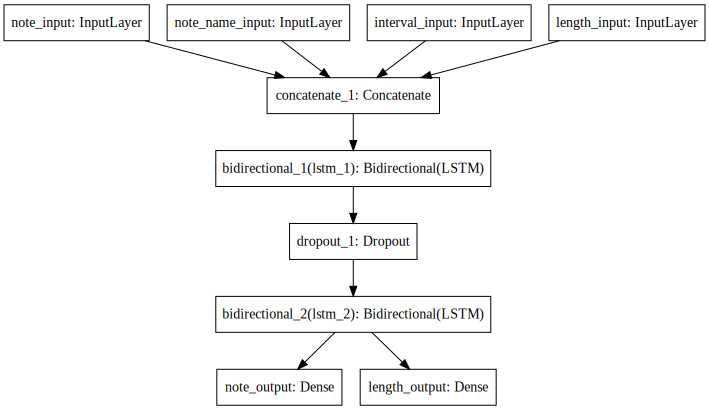

In [9]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.6
	epochs_drop = 25
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [16]:
def listen_callback(epoch, logs):
    if epoch % 100 == 0 and epoch > -1: 
    # if epoch < -2:
        print('----- Generating melody after Epoch: %d' % epoch)
        
        start_index = random.randint(0, 7000)
        for diversity in [0.5]:
            print('----- diversity:', diversity)

            current_note_phrase = notes_corpus[start_index: start_index + n_time_steps]
            current_interval_phrase = interval_corpus[start_index: start_index + n_time_steps]
            current_note_name_phrase = note_name_corpus[start_index: start_index + n_time_steps]
            current_length_phrase = length_corpus[start_index: start_index + n_time_steps]

            phrases = {
                'note_phrase': current_note_phrase, 
                'length_phrase': current_length_phrase,
                'interval_phrase': current_interval_phrase,
                'note_name_phrase': current_note_name_phrase,
            }

            generated_notes = []
            generated_lengths = []
            generated_notes.extend(current_note_phrase)
            generated_lengths.extend(current_length_phrase)

            # model, phrases,categorized_variables, lookup_indicies, n_time_steps, diversity, n_to_generate
            for step in range(40):
                encoded_prediction = make_encoded_prediction(
                    model=model,
                    phrases=phrases,
                    categorized_variables=categorized_variables,
                    lookup_indicies=lookup_indicies,
                    n_time_steps=n_time_steps
                )

                predictions = decode_predictions(
                    encoded_prediction=encoded_prediction,
                    lookup_indicies=lookup_indicies,
                    temperature=diversity
                )

                generated_notes.append(predictions['note_prediction']) 
                generated_lengths.append(predictions['length_prediction']) 


                last = generated_notes[0]
                phrases['note_phrase'] = np.append(phrases['note_phrase'][1:], predictions['note_prediction'])
                phrases['interval_phrase'] = map_midi_to_interval(phrases['note_phrase'], last)
                phrases['note_name_phrase'] = map_midi_to_note_number(phrases['note_phrase'])
                phrases['length_phrase'] = np.append(phrases['length_phrase'][1:], predictions['length_prediction'])

                print
                
            play_generated_phrase(
                generated_notes=generated_notes[10:],
                generated_lengths=generated_lengths[10:],
                player=player)

In [17]:
lrate = LearningRateScheduler(step_decay)

In [18]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(datetime.datetime.now()), histogram_freq=0, write_graph=True)

In [19]:
listen_callback = LambdaCallback(on_epoch_end=listen_callback)

In [21]:
logger('TRAINING')
model.fit([note_x, note_name_x, interval_x, length_x], [note_y, length_y],
          batch_size=batch_size,
          epochs=1500,
          callbacks=[
              listen_callback,
#               tensorboard,
            ]
          )

          **********************************
            TRAINING
          **********************************
Epoch 1/300
768/778 [============================>.] - ETA: 0s - loss: 4.1226 - note_output_loss: 2.6509 - length_output_loss: 2.9434----- Generating melody after Epoch: 0
----- diversity: 0.5
63.0 | 0.46
68.0 | 0.46
70.0 | 0.51
63.0 | 0.42
66.0 | 0.46
69.0 | 0.37
71.0 | 0.28
72.0 | 0.37
64.0 | 0.79
0 | 2.5
72.0 | 0.37
70.0 | 0.23
68.0 | 0.28
67.0 | 0.33
66.0 | 0.37
63.0 | 0.33
59.0 | 0.28
58.0 | 0.42
60.0 | 0.37
61.0 | 0.42
0 | 0.51
66 | 0.56
68 | 0.37
69 | 0.42
0 | 0.42
0 | 0.37
0 | 0.51
68 | 0.56
67 | 0.56
65 | 0.23
60 | 0.28
62 | 0.28
70 | 0.33
55 | 0.33
59 | 0.33
60 | 0.33
62 | 0.23
62 | 0.33
65 | 0.23
62 | 0.23
65 | 0.28
67 | 0.51
70 | 0.28
60 | 0.28
67 | 0.28
60 | 0.28
69 | 0.28
69 | 0.28
68 | 0.28
69 | 0.19
0 | 0.28
69 | 0.33
67 | 0.28
67 | 0.28
71 | 0.28
69 | 0.28
0 | 0.28
63 | 0.28
50 | 0.28
75 | 0.28
778/778 [==============================] - 25s 32ms/step - loss: 4

778/778 [==============================] - 1s 1ms/step - loss: 4.0226 - note_output_loss: 2.5592 - length_output_loss: 2.9270
Epoch 54/300
778/778 [==============================] - 1s 1ms/step - loss: 4.0041 - note_output_loss: 2.5485 - length_output_loss: 2.9111
Epoch 55/300
778/778 [==============================] - 1s 967us/step - loss: 4.0128 - note_output_loss: 2.5505 - length_output_loss: 2.9247
Epoch 56/300
778/778 [==============================] - 1s 977us/step - loss: 4.0141 - note_output_loss: 2.5530 - length_output_loss: 2.9222
Epoch 57/300
778/778 [==============================] - 1s 1ms/step - loss: 4.0185 - note_output_loss: 2.5550 - length_output_loss: 2.9269
Epoch 58/300
778/778 [==============================] - 1s 1ms/step - loss: 4.0288 - note_output_loss: 2.5721 - length_output_loss: 2.9134
Epoch 59/300
778/778 [==============================] - 1s 997us/step - loss: 4.0180 - note_output_loss: 2.5554 - length_output_loss: 2.9253
Epoch 60/300
778/778 [============

778/778 [==============================] - 1s 1ms/step - loss: 3.9558 - note_output_loss: 2.5035 - length_output_loss: 2.9047
Epoch 109/300
778/778 [==============================] - 1s 1ms/step - loss: 3.9178 - note_output_loss: 2.4755 - length_output_loss: 2.8846
Epoch 110/300
778/778 [==============================] - 1s 954us/step - loss: 3.9713 - note_output_loss: 2.5182 - length_output_loss: 2.9062
Epoch 111/300
778/778 [==============================] - 1s 967us/step - loss: 3.9164 - note_output_loss: 2.4716 - length_output_loss: 2.8897
Epoch 112/300
778/778 [==============================] - 1s 974us/step - loss: 3.9167 - note_output_loss: 2.4674 - length_output_loss: 2.8986
Epoch 113/300
778/778 [==============================] - 1s 955us/step - loss: 3.9562 - note_output_loss: 2.5163 - length_output_loss: 2.8799
Epoch 114/300
778/778 [==============================] - 1s 1ms/step - loss: 3.9130 - note_output_loss: 2.4696 - length_output_loss: 2.8869
Epoch 115/300
778/778 [===

778/778 [==============================] - 1s 2ms/step - loss: 3.8634 - note_output_loss: 2.4276 - length_output_loss: 2.8716
Epoch 167/300
778/778 [==============================] - 1s 1ms/step - loss: 3.8389 - note_output_loss: 2.4074 - length_output_loss: 2.8631
Epoch 168/300
778/778 [==============================] - 1s 1ms/step - loss: 3.8527 - note_output_loss: 2.4219 - length_output_loss: 2.8616
Epoch 169/300
778/778 [==============================] - 1s 1ms/step - loss: 3.8608 - note_output_loss: 2.4333 - length_output_loss: 2.8551
Epoch 170/300
778/778 [==============================] - 1s 1ms/step - loss: 3.8442 - note_output_loss: 2.4136 - length_output_loss: 2.8612
Epoch 171/300
778/778 [==============================] - 1s 1ms/step - loss: 3.8541 - note_output_loss: 2.4281 - length_output_loss: 2.8521
Epoch 172/300
778/778 [==============================] - 1s 1ms/step - loss: 3.8237 - note_output_loss: 2.3972 - length_output_loss: 2.8531
Epoch 173/300
778/778 [===========

778/778 [==============================] - 1s 1ms/step - loss: 3.7819 - note_output_loss: 2.3588 - length_output_loss: 2.8462
Epoch 222/300
778/778 [==============================] - 1s 981us/step - loss: 3.8111 - note_output_loss: 2.3877 - length_output_loss: 2.8469
Epoch 223/300
778/778 [==============================] - 1s 1ms/step - loss: 3.7705 - note_output_loss: 2.3515 - length_output_loss: 2.8381
Epoch 224/300
778/778 [==============================] - 1s 1ms/step - loss: 3.7658 - note_output_loss: 2.3463 - length_output_loss: 2.8389
Epoch 225/300
778/778 [==============================] - 1s 1ms/step - loss: 3.7685 - note_output_loss: 2.3450 - length_output_loss: 2.8469
Epoch 226/300
778/778 [==============================] - 1s 1ms/step - loss: 3.7465 - note_output_loss: 2.3252 - length_output_loss: 2.8427
Epoch 227/300
778/778 [==============================] - 1s 1ms/step - loss: 3.7486 - note_output_loss: 2.3301 - length_output_loss: 2.8371
Epoch 228/300
778/778 [=========

778/778 [==============================] - 1s 1ms/step - loss: 3.6908 - note_output_loss: 2.2804 - length_output_loss: 2.8208
Epoch 280/300
778/778 [==============================] - 1s 1ms/step - loss: 3.6839 - note_output_loss: 2.2796 - length_output_loss: 2.8085
Epoch 281/300
778/778 [==============================] - 1s 1ms/step - loss: 3.6723 - note_output_loss: 2.2655 - length_output_loss: 2.8136
Epoch 282/300
778/778 [==============================] - 1s 1ms/step - loss: 3.6860 - note_output_loss: 2.2841 - length_output_loss: 2.8039
Epoch 283/300
778/778 [==============================] - 1s 1ms/step - loss: 3.7394 - note_output_loss: 2.3226 - length_output_loss: 2.8338
Epoch 284/300
778/778 [==============================] - 1s 999us/step - loss: 3.7134 - note_output_loss: 2.3006 - length_output_loss: 2.8254
Epoch 285/300
778/778 [==============================] - 1s 1ms/step - loss: 3.6816 - note_output_loss: 2.2782 - length_output_loss: 2.8069
Epoch 286/300
778/778 [=========

In [36]:
save_model(model, 'model_2')

Saved model_2.json and model_2.h5 to disk
